In [ ]:
# Importing neccessary liberaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras.backend as K
import tensorflow as tf
import keras
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras import layers
from keras.layers import Input, GlobalAveragePooling2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,add, Flatten, Conv2D, AveragePooling2D,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.layers.merge import concatenate
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

### Retreiving the data:
Fashion MNIST is an Image dataset composed of greyscale images of clothing items such as footwear , shirts, handbags etc., with small 28 X 28 pixels. Here, there are 5 labels provided in target column from 0-4. The retreived dataset consists of 60000 values with 744 columns in training set and 10000 values with 744 image pixels in test set.

In [ ]:
# Retreiving train data
trainX = pd.read_csv('../input/fashion-mnist/trainX.csv')
trainy = pd.read_csv('../input/fashion-mnist/trainy.csv')

# Retreiving test data
testX = pd.read_csv('../input/fashion-mnist/testX.csv')
testy = pd.read_csv('../input/fashion-mnist/testy.csv')

### Preparing data:
Here, we will drop unneccesary columns like 'Id' from train and test set and prepare it to feed to CNN.

In [ ]:
x_train = trainX.drop(columns='Id')
x_test = testX.drop(columns='Id')
y_train = trainy.drop(columns='Id')
y_test = testy.drop(columns='Id')

#### Reshaping the data:
In order to input image data for classification to convolutional neural network layers, their feature dimension will be reshaped into (no. of rows/images, height, width, channel) format. As Fashion MNIST dataset consists of grayscale images, so, channel will be 1 and among 784 features 28 X 28 will be our height and width . Therefore,for training set , they will be reshaped into (60000, 28, 28, 1) and similarly, for test set they will be reshaped into (10000, 28, 28, 1).

In [ ]:
# reshape(examples, height, width, channels)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

#### Normalizing the data:
Normalizing the data is crucial part as otherwise, the model will give huge loss at some points and weird accuracy, in simple, it will not give good performanec and does not train properly. Also, as each image pixel range lies between 0 to 255. so, to normalize, it will be divided by 255 to put it in range between [0,1] for image classification.

In [ ]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

### Visualizing the Image Dataset and its nature description:
From below implementation of train set and test set images , it is visible that data is not classified according to clothes, footwear or handbags( as per original data), rather , it has been classified depending upon some other hidden pattern and generated labels by neural networks. So, there will be chances of getting less accuracy , more loss and overfitting. Therefore, in this dataset our goal will to aquire good enough accuracy and loss without much overfitting.
we can see from below images that category 1 (or 0 in dataset) consists of clothes, footwears and handbags and similarly does, the all other categories. So, our network will train and learn that hidden pattern or feature which classifies them.
In the last plot, we even checked the balancing of taget data/labels which turns out to be good.

In [ ]:
# Function that returns the images with their respective category
def plot_sample_images(x,y,len_img,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(20,12))

    for i in range(200):
        if y.iloc[i].values == 0:
            ax[0, i%8].imshow(x.reshape((len_img,28,28))[i], cmap=cmap)
            ax[0, i%8].axis('off')
            ax[0, i%8].set_title('Category 1',fontweight='bold',fontsize=14)
        
        if y.iloc[i].values == 1:
            ax[1, i%8].imshow(x.reshape((len_img,28,28))[i], cmap=cmap)
            ax[1, i%8].axis('off')
            ax[1, i%8].set_title('Category 2',fontweight='bold',fontsize=14)
        if y.iloc[i].values == 2:
            ax[2, i%8].imshow(x.reshape((len_img,28,28))[i], cmap=cmap)
            ax[2, i%8].axis('off')
            ax[2, i%8].set_title('Category 3',fontweight='bold',fontsize=14)
        if y.iloc[i].values == 3:
            ax[3, i%8].imshow(x.reshape((len_img,28,28))[i], cmap=cmap)
            ax[3, i%8].axis('off')
            ax[3, i%8].set_title('Category 4',fontweight='bold',fontsize=14)
        if y.iloc[i].values == 4:
            ax[4, i%8].imshow(x.reshape((len_img,28,28))[i], cmap=cmap)
            ax[4, i%8].axis('off')
            ax[4, i%8].set_title('Category 5',fontweight='bold',fontsize=14)
    plt.show()    

#### Train data Images:

In [ ]:
train_img= plot_sample_images(x_train,y_train,60000,'Greens')

#### Test data Images:

In [ ]:
test_img= plot_sample_images(x_test,y_test,10000)

#### Categorical distribution of Target Classes:

In [ ]:
# Get the count for each train label
label_counts_train = y_train.value_counts()
# Get the count for each test label
label_counts_test = y_test.value_counts()

# Plotting Categorical distribution of target
fig, axes= plt.subplots(1,2,figsize=(15,5))
tr =sns.barplot(np.arange(0,5),label_counts_train, ax= axes[0] )
for p,i in zip(tr.patches, np.arange(0,5)):
        tr.annotate(label_counts_train[i], (p.get_x(), p.get_height()+0.1))
tt =sns.barplot(np.arange(0,5),label_counts_test,ax= axes[1] )
for p,i in zip(tt.patches, np.arange(0,5)):
        tt.annotate(label_counts_test[i], (p.get_x(), p.get_height()+0.1))
axes[0].set_xlabel('Categories',fontweight='bold')
axes[0].set_ylabel('Count',fontweight='bold')
axes[1].set_xlabel('Categories',fontweight='bold')
axes[1].set_ylabel('Count',fontweight='bold')
axes[0].set_title('Train set Class Distribution',fontsize=16,fontweight='bold')
axes[1].set_title('Test set Class Distribution',fontsize=16,fontweight='bold')
plt.show()

# Deep Convolutional network:
## CM[6]
## Part 1 & 3 - 1st Model( Deep CNN Model)

Our first implementation will be designing simple deep convolutional neural network. 
##### Why Deep CNN:
Deep Convolutional neural network is a combination of various convolutional and pooling layers especially, designeded for image classification with large dataset. They provide better performance than simple atificial neural network and classifies well. It can work with n dimensional data. Also, they are able to learn basic filters automatically and combine them hierarchically for pattern recognition. However, many deep CNNs suffers from overfitting and takes huge time in processing because of large and complex computation.
##### How it works:
Convolutional neural networks are composed of multiple layers of artificial neurons( mathematical functions that calculate the weighted sum of multiple inputs and outputs with an activation value) .Once image is input into model, each layer generates several activation functions that will be carried on to the next layer, where the first layer usually extracts edges. AS we dive deeper, it detects more complex features such as objects, faces, etc.
In these networks, a filter is applied to a input in order to create a feature map which detects features presence in the input. The whole deep Convolutional network consists of various layers of convolution and pooling, which are then flattened and fed to fully connected dense layers. Its architecture is shown below:
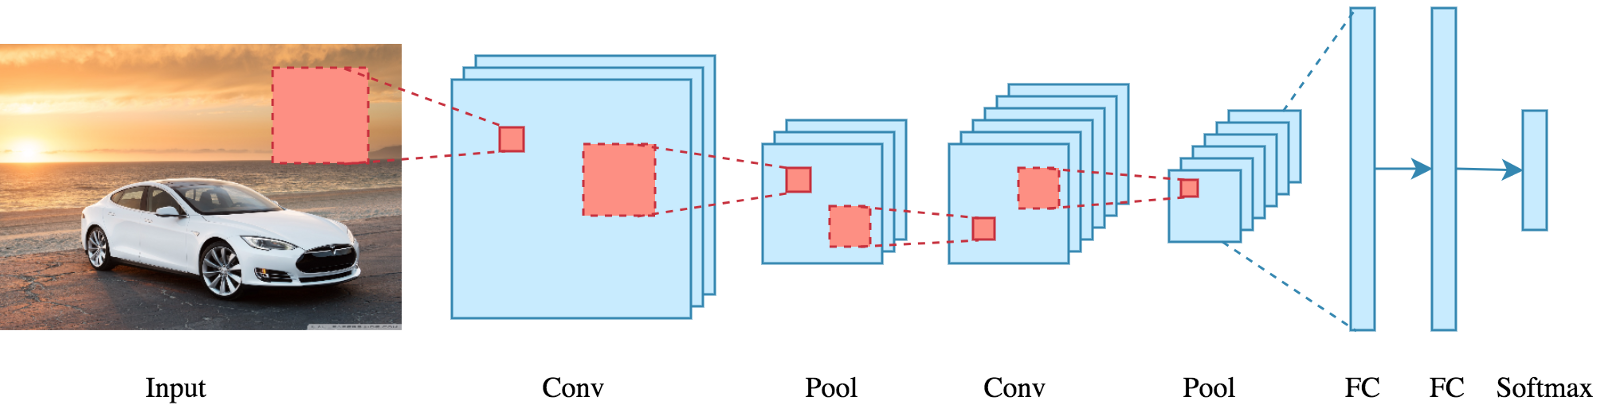

Steps to implement Deep CNN Model:
1) A sequenrial API from keras is called to create layer to layer model .

2) The first Conv2D layer is applied with input which has  32  filters of shape (3,3), 'same' padding and 'relu' activation function .

3) Then a Dropout layer is added with dropout of 0.25.

4) Now, second Conv2D layer is applied which has  64  filters of shape (5,5), 'same' padding and 'relu' activation function .

5) Then, the Max Pooling layer having pool_size of 2 is applied.

6) Then, another Dropout layer is added with dropout of 0.35.

7) Now, third Conv2D layer is applied which has  128  filters of shape (7,7), 'valid' padding and 'relu' activation function .

8) Then, the Max Pooling layer having pool_size of 2 is applied.

9) Then, another Dropout layer is added with dropout of 0.4.

10) Now, Flatten layer will applied to reshape the output from Convolutional layers and then input them to fully connected dense layers.

11) Now, a Dense layer with 600 units will be applied with activation function as 'relu'.

12) This is then followed by Dropout layer of dropout 0.5.

13) Again one more Dense layer is applied with 300 units and activation function as 'relu' .

14) This is then followed by Dropout layer of dropout 0.5.

15) The Fully Connected (Dense) layer reduces its input to the number of classes( i.e.,5)using a softmax activation .

This is how a model is designed.

##### Compiling , summarizing and plotting the architecture of model:
Finally, a model is created and compiled with
- optimizer = 'adam', it merge the best characteristics of the AdaGrad and RMSProp algorithms to provide an optimization algorithm .Thus, it can handle sparse gradients on noisy problems and relatively easy to configure.
-  loss = 'sparse_cross_entropy' as our dataset is image and sparse . Also, it a classification problem where there are more than 2 categories.
- and metrics = 'accuracy', to get the performance of model and know how efficient model is.

Once, it is compiled, its summary along with a visual plot of its architecture will be displayed.

##### Training the model:
Now, to train the model, we will fit the parameters into model as:
- train feature/input = x_train
- train target = y_train
- Validation_data = (x_test, y_test) . here, test set is fed as validation data to show runtime performance and plot of testing data, as per the assignment requirement. Else, one can do validation even without test set by inputting size of validation or retreiving the validation set by splitting training into train and validation. But, here as per requirement of Runtime performance and accuracy-loss plots of testing set, we will use testing data as validation data.
- Epochs = 30 , in order to avoid or minimize overfitting by early stopping.
- Batch_size = 128, to get fast computational results.
- verbose = 1


## CM[6]
## Part 4 - 1st Model( Deep CNN Model)
### Implementing Deep CNN Model:

In [ ]:
# Building cnn_layers_model with 4 layers 
cnn_layers_model=Sequential()

# 1 Convolutional layer
cnn_layers_model.add(Conv2D(filters=32,kernel_size=3,activation='relu',
                            padding='same',input_shape=(x_train.shape[1],x_train.shape[2],1)))
cnn_layers_model.add(Dropout(0.25))

# 2 Convolutional + Pooling layer
cnn_layers_model.add(Conv2D(filters=64,kernel_size=5,padding='same',activation='relu'))
cnn_layers_model.add(MaxPooling2D(pool_size=2))
cnn_layers_model.add(Dropout(0.35))

# # 3 Convolutional + Pooling layer
cnn_layers_model.add(Conv2D(filters=128,kernel_size=7,activation='relu'))
cnn_layers_model.add(MaxPooling2D(pool_size=2))
cnn_layers_model.add(Dropout(0.4))

# Flatten layer
cnn_layers_model.add(Flatten())

# Dense Layers
cnn_layers_model.add(Dense(600,activation='relu'))
cnn_layers_model.add(Dropout(0.5))
cnn_layers_model.add(Dense(300,activation='relu'))
cnn_layers_model.add(Dropout(0.5))
cnn_layers_model.add(Dense(5,activation='softmax'))

# Compiling the model
cnn_layers_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Summarizing the model
cnn_layers_model.summary()

### Plotting Deep CNN Model Architecture:

In [ ]:
# plot model architecture
plot_model(cnn_layers_model, to_file='cnn_layers_model.png')

## CM[7]
## Part 1 - 1st Model( Deep CNN Model)
### Runtime Performance of Training and Testing with Deep CNN Model:
In Runtime performance , the training data achieved accuracy of ====== and loss of =====, whereas , the test data achieved accuracy of ===== and loss of ========. Although, the training set achieved maximum accuracy of ==== at ===== epoch and test set almost fluctuate in same level and achieved maximum accuracy of ===== at ====== within 30 epochs.

In [ ]:
deep_cnn_history=cnn_layers_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,batch_size=128,verbose=1)

### Evaluation of Testing with Deep CNN Model:

In [ ]:
deep_cnn_score=cnn_layers_model.evaluate(x_test,y_test,verbose=0)
print('The loss while evaluation of test data with Deep CNN is: {} '.format(deep_cnn_score[0]))
print('The accuracy while evaluation of test data with Deep CNN is: {} '.format(deep_cnn_score[1]))

# CM[7]
## Part 3 - 1st Model( Deep CNN Model)
### Plotting Loss and Accuracy vs. Epochs of Deep CNN Model:
Here,the below plots shows the accuracy and loss rate with respect to epochs, where, training set accuracy keeps on increasing and loss is decreasing, but in case of test set, the accuracy is not increasing as significantly as of training set and same is for the loss, it is also not decreasing as significantly as loss of training set. But, the good thing is its still increasing with slower pace and thus, learning. Although, this model can easily achieve accuracy around 97 -98% for training set ( without dropout layers), but that will be overfitting the model . So, dropout layers are introduced to deal with it and dense layers are used for more better performance. Apart from this, the labels of this dataset are also classified with some hidden pattern , even confusing to human eye. So, our accuracy is quite good in such condition and further, we will impove it or atleast try with different implementations to improve it.

In [ ]:
fig, axes= plt.subplots(1,2,figsize=(15,5))
axes[0].plot(deep_cnn_history.history['loss'],label='Training loss',color='red')
axes[0].plot(deep_cnn_history.history['val_loss'],label='Testing loss',color='red',linestyle ='dashed')
axes[1].plot(deep_cnn_history.history['accuracy'],label='Training accuracy',color='green')
axes[1].plot(deep_cnn_history.history['val_accuracy'],label='Testing accuracy',color='green',linestyle ='dashed')
axes[0].set_xlabel('Epochs',fontweight='bold')
axes[0].set_ylabel('Loss',fontweight='bold')
axes[1].set_xlabel('Epochs',fontweight='bold')
axes[1].set_ylabel('Accuracy',fontweight='bold')
axes[0].set_title('Deep CNN Training and Testing Loss \n vs. Epochs',fontsize=16,fontweight='bold')
axes[1].set_title('Deep CNN Training and Testing Accuracy \n vs. Epochs',fontsize=16,fontweight='bold')
axes[0].legend()
axes[1].legend()
plt.show()

### Visualizing True and Predicted Class with Deep CNN Model:
This barplot displays the true and preducted class labels, where Deep CNN seems to have almost similar error in prediction in all categories.

In [ ]:
# Function that returns True and Predicted barplot
def true_pred(model,model_name):
    predict = model.predict(x_test)
    pred=np.argmax(predict,axis=1)
    pred = pd.DataFrame(pred)
    plt.figure(figsize=(10,3))
    plt.bar(np.arange(0,5)+0.1,y_test.value_counts(),width=0.4, label = 'True')
    plt.bar(np.arange(0,5)+0.5,pred.value_counts(),width=0.4, label = 'Predicted')
    plt.xlabel('Categories',fontweight='bold')
    plt.ylabel('Count',fontweight='bold')
    plt.legend()
    plt.title('True vs. Predicted Comparision of {}'.format(model_name),fontweight='bold',fontsize= 16)
# Function that return the num no. of images of actual data and its true and predicted classes
def Vis_true_pred(model,num):
    predict = model.predict(x_test)
    pred=np.argmax(predict,axis=1)
    f, ax = plt.subplots(int(num/10),10, figsize=(20,5*int((num/20)+0.5)))
    for i in range(num):
        ax[i//10, i%10].imshow(x_test.reshape((10000,28,28))[i])
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].set_title('Original: {},\n  Predicted: {}'.format(y_test.iloc[i].values,
                                                                pred[i]),fontsize=14)
    plt.show()

deep_cnn_true_pred= true_pred(cnn_layers_model,'Deep CNN Model') 

### True and Predicted visualization of 20 images of Deep CNN Model:
The below plot displays the actual 20 images with their original category and their predicted ones. Here, there === categories which are predicted wrong.

In [ ]:
# True and Predicted visualization of 20 images 
deep_cnn_visualization= Vis_true_pred(cnn_layers_model,20)

# CNN With Inception:
## CM[6]
## Part 2 & 3 - 2nd Model( CNN With Inception)

#### Why CNN With Inception:
In 1st model, it is visible that as we go deeper or add more layers to a Neural Network . To avoid overfitting, we added dropout layers which decreased the training accuracy from around 97-98 to 90 and similarly for loss, we reached minimum at 0.2, and its not decreasing anymore. So, we need to built a model providing good performance . Therefore, Inception model is consirdered one of the good choice as it attained more than 78.1% of accuracy on ImageNet dataset and various other Image datasets. Also, in this not only depth of the model will be increased but also, the width  to boost the performance of network. Furthermore, the upcoming explaination with designing will show more of its characteristics.
#### Designing Inception Model:
In Convolutional Neural Networks (CNNs), the important job is to choose right layers with right filters, to find the optimal solution. The inception module is created with Conv2D and pooling layers  (1x1 filter, 3x3 filter, 5x5 filter or max-pooling) , which were concatenated later . After this, these 'Inception modules' are stacked upon each other. Thus, their output correlation statistics will vary, as higher layers captures features of higher abstraction and their spatial concentration is expected to decrease suggesting that the ratio of 3×3 and 5×5 convolutions should increase as we move to higher layers. Therefore, their computational cost will also increase that is why in second figure, dimension reduction technique is used through 1X1 convolutions. GoogleNet is one of the famous Inception-based algorithm. Below shown are the two verions of Inception model, one is naive version without and dumensionatlity reduction and other, comes with the property of dimensionality reduction by adding layer of 1X1 layers. We have implemented the inception model with dimensionality reduction.
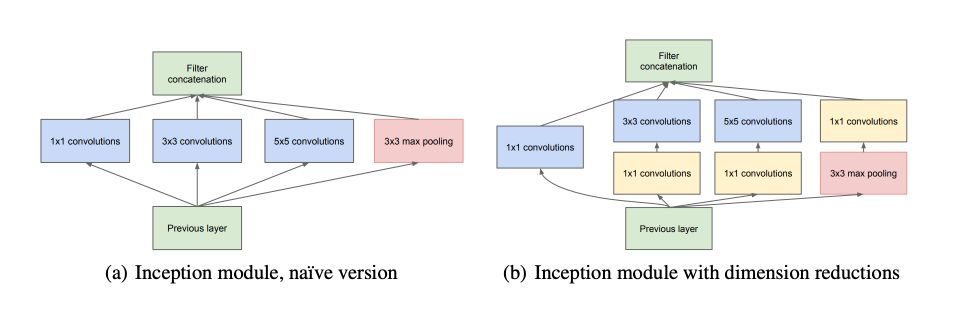

##### Inception Module:
Steps to implement the Inception Module:

Filter 1 - 1X1 Convolutional layer:
- The first CONV2D has  f1  filters of shape (1,1) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.

Filter 2 - 3X3 Convolutional layers:
- The CONV2D has  f2_in  filters of shape (1,1) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.
- The CONV2D has  f2_out  filters of shape (3,3) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.

Filter 3 - 5X5 Convolutional layers
- The CONV2D has  f3_in  filters of shape (1,1) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.
- The CONV2D has  f3_out  filters of shape (5,5) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.

Filter 4 - 3X3 Max Pooling layer
- The Max Pooling uses a window of shape (3,3) with stride of size (2,2) and 'same' padding.
- The CONV2D has  f4_out  filters of shape (1,1) with 'same' padding, 'relu' activation function and l1_l2 kernel_regularizer is applied.
Concatenate all filters:
- The four filetrs achieved namely, conv1, conv2, conv3 and pool will be concatenated.

Here, L1_L2 regularizers makes the model to generalize better , improves the model's performance on the unseen data as well and thus, avoid overfitting.
##### Building the Inception Model:
As, we have achieved 7 layers of the inception module, they will be concatenated and then, stacked together to make one inception model. In this model, aound 23 layers will be implemented including two inception modules.

Steps to implement our Inception Model with CNN are:
1) Input is provided with shape of (28, 28, 1).

2) inception_module function will be called to apply inception layer with filters (64, 96, 128, 16, 32, 32).

3) BatchNirmalization layer will be applied as, its a deep model so, it will reduce and generalization error during training and boost up the speed.

4) another inception layer will b e applied with filters (128, 128, 192, 32, 96, 64).

5) Now, Flatten layer will applied to reshape the output from Convolutional layers and then input them to fully connected dense layers.

6) Now, a Dense layer with 64 units will be applied with activation function as 'relu' and l1_l2 regularizer to handle overfitting.

7) This is then followed by Dropout layer.

8) Again one more Dense layer is applied with 128 units and activation function as 'relu' and l1_l2 kernel regularizers.

9) This is then followed by Dropout layer.

10) The Fully Connected (Dense) layer reduces its input to the number of classes( i.e.,5)using a softmax activation and l1_l2 kernel regularizers.

11) The Model is created and trained an with given inputs and predicted output from above layers.

##### Compiling , summarizing and plotting the architecture of model:
Finally, a model is created and compiled with
- optimizer = 'adam', it merge the best characteristics of the AdaGrad and RMSProp algorithms to provide an optimization algorithm .Thus, it can handle sparse gradients on noisy problems and relatively easy to configure.
-  loss = 'sparse_cross_entropy' as our dataset is image and sparse . Also, it a classification problem where there are more than 2 categories.
- and metrics = 'accuracy', to get the performance of model and know how efficient model is.

Once, it is compiled, its summary along with a visual plot of its architecture will be displayed.

##### Training the model:
Now, to train the model, we will fit the parameters into model as:
- train feature/input = x_train
- train target = y_train
- Validation_data = (x_test, y_test) . here, test set is fed as validation data to show runtime performance and plot of testing data, as per the assignment requirement. Else, one can do validation even without test set by inputting size of validation or retreiving the validation set by splitting training into train and validation. But, here as per requirement of Runtime performance and accuracy-loss plots of testing set, we will use testing data as validation data.
- Epochs = 30 , in order to avoid or minimize overfitting by early stopping.
- Batch_size = 128, to get fast computational results.
- verbose = 1


## CM[6]
## Part 4 - 2nd Model( CNN With Inception)
### Implementing CNN With Inception Model:

In [ ]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu',
                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu'
                  ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu'
                  ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu'
                  ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu'
                  ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu'
                 ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out
 
# define model input
visible = Input(shape=(28, 28, 1))

# add inception layer 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer= BatchNormalization()(layer)

# add inception layer 2
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

# Flatten layer
layer = Flatten()(layer)

# Dense layers
layer = Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer)
layer = Dropout(0.3)(layer)
layer = Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer)
layer = Dropout(0.3)(layer)
output_layer = Dense(5,activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer)

# create model
cnn_inception_model = Model([visible], [output_layer])

# Compile model
cnn_inception_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',
                            metrics = ['accuracy'])

# summarize model
cnn_inception_model.summary()

### Plotting CNN Inception Model Architecture:

In [ ]:
# plot model architecture
plot_model(cnn_inception_model, show_shapes=True, to_file='inception_module.png')

## CM[7]
## Part 1 - 3rd Model( CNN Inception Model)
### Runtime Performance of Training and Testing with CNN Inception Model:
In Runtime performance , the training data achieved accuracy of ====== and loss of =====, whereas , the test data achieved accuracy of ===== and loss of ========. Although, the training set achieved maximum accuracy of ==== at =====epoch and test set almost fluctuate in same level and achieved maximum accuracy of ===== at ======.

In [ ]:
cnn_inception_history=cnn_inception_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,batch_size=128,verbose=1)

### Evaluation of Testing with CNN Inception Model:

In [ ]:
cnn_inception_score=cnn_inception_model.evaluate(x_test,y_test,verbose=0)
print('The loss while evaluation of test data with Deep CNN is: {} '.format(cnn_inception_score[0]))
print('The accuracy while evaluation of test data with Deep CNN is: {} '.format(cnn_inception_score[1]))

## CM[7]
## Part 3 - 2nd Model( CNN Inception Model)
### Plotting of Loss and Accuracy vs. Epochs of CNN Inception Model:
Here,the below plots shows the accuracy and loss rate with respect to epochs, where, training set accuracy keeps on increasing and loss is decreasing, but in test set, there seems to be no change in accuracy and loss and, even after applying the batchnormalization on layers, test set training has fluctuations . This may be due to some elements in the dataset are randomly classified. Also, as our test set accuracy in not increasing and its loss is not decreasing .So, overfitting can be problem and if it so, then the L1-L2 regularization is applied with a dropout layer, which avoided the problem. As, without regularization and dropout layer, model was giving good accuracy of about 99.5 on training but, worse in test set such as, the test loss started increasing and test accuracy started decreasing on test set at significant rate. So, the dropout and regularization avoided overfitting and further may be vanishing gradient problem in neural networks to some extent , but still, in our case, an even better model is required. Apart from it, after trying many hyperparameters and adding dense layers using Inception concept, this is the best one inception with CNN model achieved.

In [ ]:
fig, axes= plt.subplots(1,2,figsize=(15,5))
axes[0].plot(cnn_inception_history.history['loss'],label='Training loss',color='red')
axes[0].plot(cnn_inception_history.history['val_loss'],label='Testing loss',color='red',linestyle ='dashed')
axes[1].plot(cnn_inception_history.history['accuracy'],label='Training accuracy',color='green')
axes[1].plot(cnn_inception_history.history['val_accuracy'],label='Testing accuracy',color='green',linestyle ='dashed')
axes[0].set_xlabel('Epochs',fontweight='bold')
axes[0].set_ylabel('Loss',fontweight='bold')
axes[1].set_xlabel('Epochs',fontweight='bold')
axes[1].set_ylabel('Accuracy',fontweight='bold')
axes[0].set_title('CNN With Inception Training and \n Testing Loss vs. Epochs',fontsize=16,fontweight='bold')
axes[1].set_title('CNN With Inception Training and \n Testing Accuracy vs. Epochs',fontsize=16,fontweight='bold')
axes[0].legend()
axes[1].legend()
plt.show()

### Visualizing True and Predicted Class with CNN Inception Model:
This barplot displays the true and preducted class labels, where Inception with CNN Model seems to have more false positives in Category 0. Other categories, seems to have less error in prediction.

In [ ]:
cnn_inception_true_pred= true_pred(cnn_inception_model,'Inception CNN Model')

### True and Predicted visualization of 20 images of Inception CNN Model:
The below plot displays the actual 20 images with their original category and their predicted ones. Here, there === categories which are predicted wrong.

In [ ]:
# True and Predicted visualization of 20 images
cnn_inception_visualization= Vis_true_pred(cnn_inception_model,20)

# CNN With Resnet50
## CM[6]: 
## Part 2 & 3 - 3rd Model( Resnet50)

### Why Resnet50:
From previous observation, it is visible that as we go deeper or add more layers to a Neural Network , it can make model more robust for image-related tasks, but also leads to loosing accuracy.This may be due to overfitting, but in that case,that can be solved using dropout and regularization techniques.So, another possible reason for bad performance can be vanishing gradient problem. That’s why we are going to implement a deep CNN with new approach known as Resnet50, to avoid that problem (if it so).

### Designing the CNN Resnet50 Model:
Resnet50 is a deep CNN with 50 layers consisting of convolutional and identity blocks and then combined ia form to give good results. The residual units or blocks which have skip connections, are called identity connections in resnet which allows the gradient to be directly backpropagated to earlier layers.

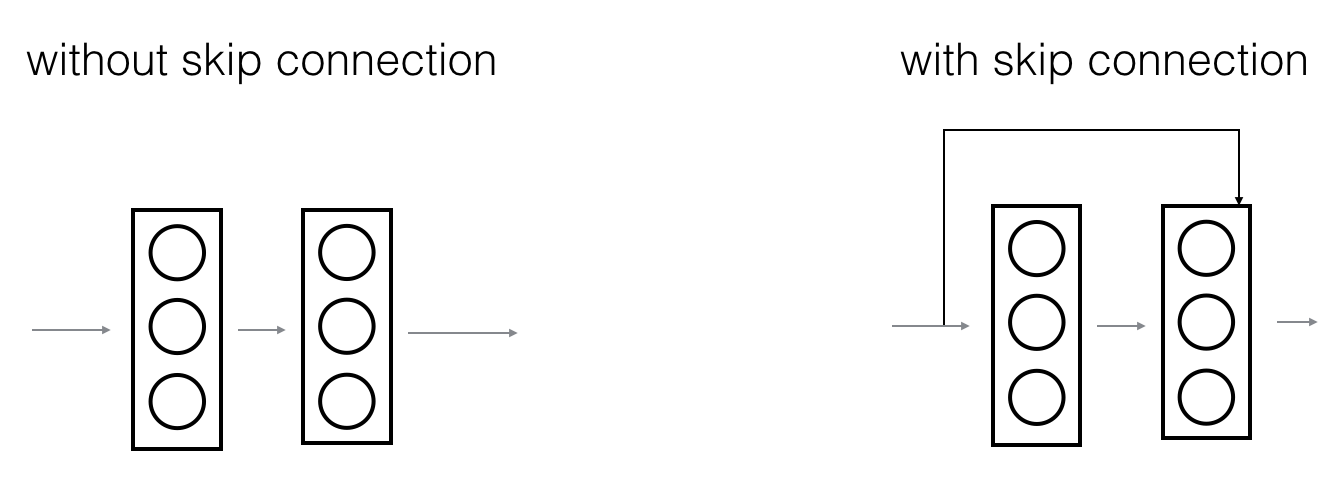
The left image shows mainpath whereas the other one added shortcut to the main path which makes convinient for blocks to learn the identity function. So, these blocks wilk be stacked upon each other in order to get Resnet50 deep neural network, but there will be chances of harming the tarining performance . Further, two main blocks of resnet will be implemented, namely identity and convolutional blocks.

##### Identity Block :
These are the standard blocks and are suitable for the cases where input and output activation functions have same dimensions.The below diagram reperesents the Identity block with both shortcut and main path and, Conv2D , ReLu and BacthNormalization layers.
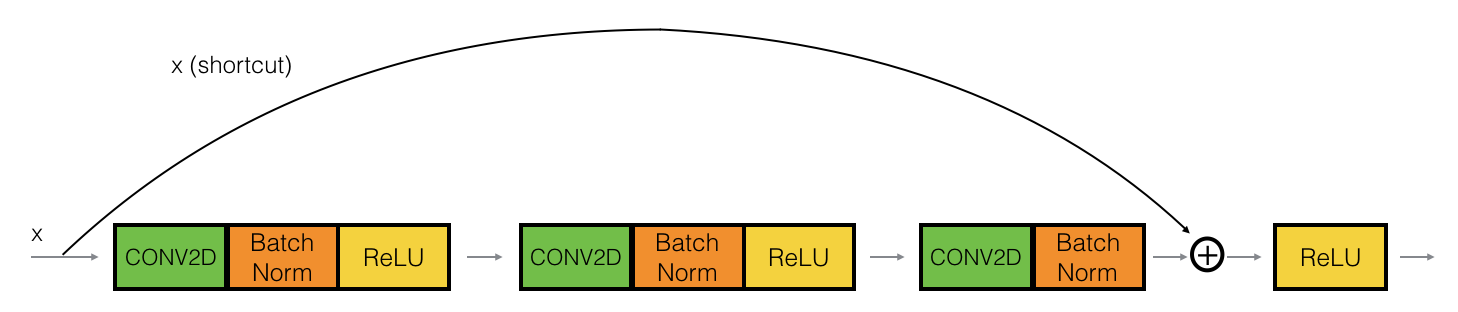

The steps followed to implement Identity block are as follows:

First component of main path:
- The first CONV2D has  F1  filters of shape (1,1) and a stride of (1,1) with 'valid' padding and kerenel initializer as glorot_uniform with random seed =0 .This layer will be named as conv_name_base + '2a'. 
- The first BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2a'.
- Then, ReLU activation function is applied without any name or hyperparameters.

Second component of main path:
- The second CONV2D has  F2  filters of shape  (f,f)  and a stride of (1,1) with 'same' padding and kerenel initializer as glorot_uniform with random seed =0 .This layer will be named as conv_name_base + '2b'. 
- The second BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2b'.
- Then, ReLU activation function is applied without any name or hyperparameters.

Third component of main path:

- The third CONV2D has  F3  filters of shape (1,1) and a stride of (1,1) with 'valid' padding and kerenel initializer as glorot_uniform with random seed =0 .This layer will be named as conv_name_base + '2c'.
- The third BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2c'.

Final step:

- The shortcut and the input are added together.
- Then, ReLU activation function is applied without any name or hyperparameters.
##### The convolutional block
Now, the other block will be implemented where Con2D layer is added even to shortcut to resize the input  x  to a different dimension and Thus, unlike identity block, here input and output activation functions can have different dimensions because with this Conv layer, the dimensions will match up in the final addition through shortcut.  Below is the figure of representation of convolutional network.
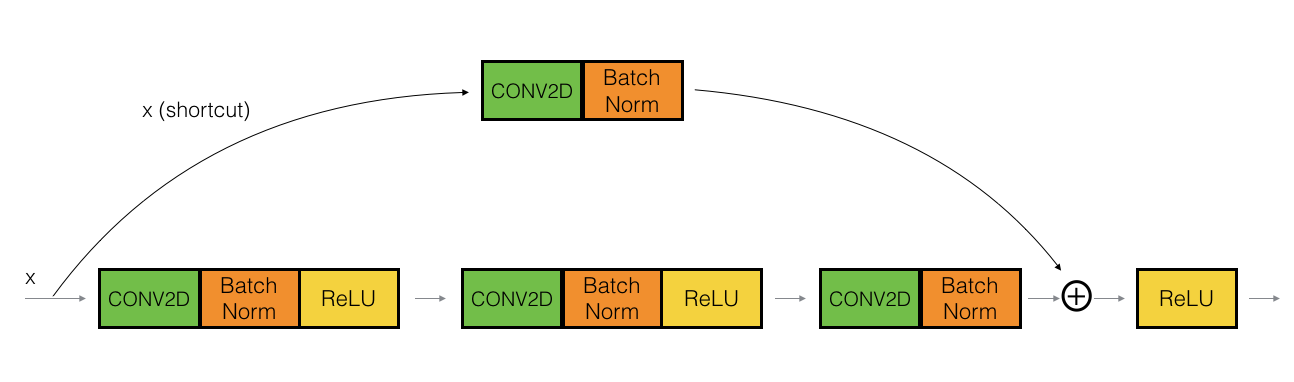

The Steps of the convolutional block are as follows.

First component of main path:
- The first CONV2D has  F1  filters of shape (1,1) and a stride of (s,s) with 'valid' padding and name as conv_name_base + '2a'.
- The first BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2a'.
- Then, ReLU activation function is applied without any name or hyperparameters.

Second component of main path:
- The second CONV2D has  F2  filters of (f,f) and a stride of (1,1) with 'same' padding and name as conv_name_base + '2b'.
- The second BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2b'.
- Then, ReLU activation function is applied without any name or hyperparameters.

Third component of main path:
- The third CONV2D has  F3  filters of (1,1) and a stride of (1,1) with 'valid' padding and name as conv_name_base + '2c'.
- The third BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '2c', without any  ReLU activation function.

Shortcut path:
- The CONV2D has  F3  filters of shape (1,1) and a stride of (s,s) with 'valid' padding and name as conv_name_base + '1'.
- The BatchNorm is normalizing the channels axis = 3 with name as bn_name_base + '1'.

Final step:
- The shortcut and the main path values are added together.
- Then, ReLU activation function is applied without any name or hyperparameters.
##### Building your first ResNet model (50 layers)
Once, identity and convolution blocks are achieved , the next step is put them together to form structure of resnet50. Below is the representation of Resnet50 model with both blocks stacked.
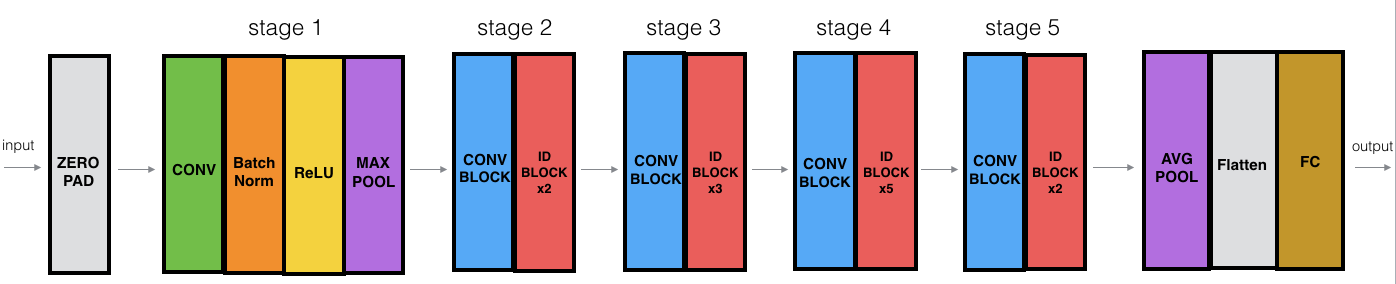

The steps of this ResNet-50 model are:
1) Input is provided with shape of( 28, 28, 1)

2) Zero-padding with pad= (3,3)

3) Stage 1:
- The 2D Convolution has 64 filters of shape (7,7) with stride of (2,2) and name as "conv1".
- BatchNorm is applied to the channels axis = 3.
- MaxPooling uses a (3,3) window with a (2,2) stride.

4) Stage 2:
- The convolutional block uses three set of filters of size [64,64,256], where "f" is 3, "s" is 1 and the block is "a".
- The 2 identity blocks use three set of filters of size [64,64,256], where "f" is 3 and the blocks are "b" and "c".

5) Stage 3:
- The convolutional block uses three set of filters of size [128,128,512], where "f" is 3, "s" is 2 and the block is "a".
- The 3 identity blocks use three set of filters of size [128,128,512], where "f" is 3 and the blocks are "b", "c" and "d".

6) Stage 4:
- The convolutional block uses three set of filters of size [256, 256, 1024], where "f" is 3, "s" is 2 and the block is "a".
- The 5 identity blocks use three set of filters of size [256, 256, 1024], where "f" is 3 and the blocks are "b", "c", "d", "e" and "f".

7) Stage 5:
- The convolutional block uses three set of filters of size [512, 512, 2048], where "f" is 3, "s" is 2 and the block is "a".
- The 2 identity blocks use three set of filters of size [512, 512, 2048], where "f" is 3 and the blocks are "b" and "c".

8) The 2D Average Pooling uses a window of shape (1,1) as the input has height and width of 28 X 28 ,and with commonly used (2X2) shape , error will arise . Its name is "avg_pool".

9) Flatten layer with 1 BatchNormalization layer.
- The flatten doesn't have any hyperparameters or name, and is used to flatten the dimensions for applying futher dense layers.
- Then, a BatchNormalization layer will be applied to normalize, reduce generalization error and boost up the training speed.

10) 3 Dense layers with 3 BatchNormalization and 3 Dropout layers
- After this a Dense layers is applied with 256 units and ReLu activation function.
- It is then followed by Dropout layer with dropout of 0.5 to reduce overfitting.
- Again , a BatchNormalization layer will be applied.

- Another Dense layer is applied  with 128 units and ReLu activation function.
- It is then followed by Dropout layer with dropout of 0.5 to reduce overfitting.
- Again , a BatchNormalization layer will be applied.

- One more, Dense layer is applied  with 64 units and ReLu activation function.
- It is then followed by Dropout layer with dropout of 0.5 to reduce overfitting.
- Again , a BatchNormalization layer will be applied.

11) The Fully Connected (Dense) layer reduces its input to the number of classes( i.e.,5)using a softmax activation with name should be 'fc' + str(classes).

12) The Model is created and trained an with given inputs and predicted output from above layers.

##### Compiling , summarizing and plotting the architecture of model:
Finally, a model is created and compiled with
- optimizer = 'adam', it merge the best characteristics of the AdaGrad and RMSProp algorithms to provide an optimization algorithm .Thus, it can handle sparse gradients on noisy problems and relatively easy to configure.
-  loss = 'sparse_cross_entropy' as our dataset is image and sparse . Also, it a classification problem where there are more than 2 categories.
- and metrics = 'accuracy', to get the performance of model and know how efficient model is.

Once, it is compiled, its summary along with a visual plot of its architecture will be displayed.

##### Training the model:
Now, to train the model, we will fit the parameters into model as:
- train feature/input = x_train
- train target = y_train
- Validation_data = (x_test, y_test) . here, test set is fed as validation data to show runtime performance and plot of testing data, as per the assignment requirement. Else, one can do validation even without test set by inputting size of validation or retreiving the validation set by splitting training into train and validation. But, here as per requirement of Runtime performance and accuracy-loss plots of testing set, we will use testing data as validation data.
- Epochs = 30 , in order to avoid or minimize overfitting by early stopping.
- Batch_size = 128, to get fast computational results.
- verbose = 1


## CM[6]
## Part 4 - 3rd Model( Resnet50)
### Implementation of  the CNN Resnet50 Model:

In [ ]:
# Function that returns Identity blocks of Resnet50
def identity_block(x,f,filters,stage,block):
    # defining name
    conv_name_base= 'res' + str(stage) + block + '_branch'
    bn_name = 'bn' + str(stage) + block + '_branch'
    
    # Retreive filters
    F1, F2, F3 = filters
    
    # saving input value for later need pf adding back to the main path
    x_shortcut = x
    
    # first component of main path
    x = Conv2D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2a')(x)
    x = Activation('relu')(x)
    
    # second component of main path
    x = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2b')(x)
    x = Activation('relu')(x)

    # third component of main path
    x = Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2c')(x)
    
    # Adding the original input to main path and applying relu activation
    x = Add()([x,x_shortcut])
    x= Activation('relu')(x)
    
    return x

# Function that returns convolutional blocks of Resnet50
def convolutional_block(x,f,filters,stage,block,s=2):
    # defining name
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name = 'bn' + str(stage) + block + '_branch'
    
    # Retreive filters
    F1, F2, F3 = filters
    
    # saving input value for later need pf adding back to the main path
    x_shortcut = x
    
    # main path
    # first component of main path
    x = Conv2D(filters = F1, kernel_size = 1, strides = s, name = conv_name_base + '2a',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2a')(x)
    x = Activation('relu')(x)
    
    # second component of main path
    x = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2b')(x)
    x = Activation('relu')(x)

    # third component of main path
    x = Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c',
               kernel_initializer =glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis= 3 , name= bn_name + '2c')(x)
    
    # shortcut path
    x_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = s, name = conv_name_base + '1',
                     kernel_initializer =glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis= 3 , name= bn_name + '1')(x_shortcut)
    
    # Adding the original input to main path and applying relu activation
    x = Add()([x,x_shortcut])
    x= Activation('relu')(x)
    
    return x

# Function that returns model of Resnet50
def Resnet50(input_shape= (28,28,1), classes =5):
    # defining input
    x_input= Input(input_shape)
    
    # Converting 1 to 3 channel
#     x = Conv2D(3,(1,1),padding='same')(x_input)
    # zeropadding
    x = ZeroPadding2D((3,3))(x_input)
    
    # Stage 1
    x = Conv2D(filters=64,kernel_size=7,strides=2,name='conv1',kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3,name ='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3,strides = 2)(x)
    
    # Stage 2
    x = convolutional_block(x, f=3, filters= [64,64,256],stage = 2,block='a',s=1)
    x = identity_block(x,3,[64,64,256],stage=2,block ='b')
    x = identity_block(x,3,[64,64,256],stage=2,block ='c')
    
    # Stage 3
    x = convolutional_block(x, f=3, filters= [128,128,512],stage = 3,block='a',s=2)
    x = identity_block(x,3,[128,128,512],stage=3,block ='b')
    x = identity_block(x,3,[128,128,512],stage=3,block ='c')
    x = identity_block(x,3,[128,128,512],stage=3,block ='d')
    
    # Stage 4
    x = convolutional_block(x, f=3, filters= [256,256,1024],stage = 4,block='a',s=2)
    x = identity_block(x,3,[256,256,1024],stage=4,block ='b')
    x = identity_block(x,3,[256,256,1024],stage=4,block ='c')
    x = identity_block(x,3,[256,256,1024],stage=4,block ='d')
    x = identity_block(x,3,[256,256,1024],stage=4,block ='e')
    x = identity_block(x,3,[256,256,1024],stage=4,block ='f')   
    
    # Stage 5
    x = convolutional_block(x, f=3, filters= [512,512,2048],stage = 5,block='a',s=2)
    x = identity_block(x,3,[512,512,2048],stage=5,block ='b')
    x = identity_block(x,3,[512,512,2048],stage=5,block ='c')
    
    # Average pooling
    x = AveragePooling2D((1,1),name= 'avg_pool')(x)
    
    # output layer
    x = Flatten()(x)
    x= BatchNormalization()(x)
    x= Dense(256, activation='relu')(x)
    x= Dropout(0.5)(x)
    x= BatchNormalization()(x)
    x= Dense(128, activation='relu')(x)
    x= Dropout(0.5)(x)
    x= BatchNormalization()(x)
    x= Dense(64, activation='relu')(x)
    x= Dropout(0.5)(x)
    x= BatchNormalization()(x)
    x = Dense(classes , activation ='softmax', name='fc' + str(classes),kernel_initializer = glorot_uniform(seed=0))(x)
    
    # create model
    model = Model(inputs = x_input , outputs = x, name = 'Resnet50')
    
    return model

# Calling the model
resnet50_model = Resnet50()

# Compiling the model
resnet50_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Summarizing the model
resnet50_model.summary()

### Plotting of CNN Resnet50 Model Architecture:

In [ ]:
# Plotting the Resnet50 model
plot_model(resnet50_model, show_shapes=True, to_file='resnet50_model.png')

## CM[7]
## Part 1 - 3rd Model( Resnet50)
### Runtime Performance of Training and Testing of CNN Resnet50 Model:
In Runtime performance , the training data achieved accuracy of ====== and loss of =====, whereas , the test data achieved accuracy of ===== and loss of ========. Although, the training set achieved maximum accuracy of ==== at =====epoch and test set almost fluctuate in same level and achieved maximum accuracy of ===== at ======.

In [ ]:
resnet50_history= resnet50_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,batch_size=128,verbose=1)

### Evaluation of Testing with CNN Resnet50 Model:

In [ ]:
resnet50_score=resnet50_model.evaluate(x_test,y_test,verbose=0)
print('The loss while evaluation of test data with Resnet50 CNN is: {} '.format(resnet50_score[0]))
print('The accuracy while evaluation of test data with Resnet50 CNN is: {} '.format(resnet50_score[1]))

## CM[7]
## Part 3 - 3rd Model( Resnet50)
### Plotting of Loss and Accuracy vs. Epochs of CNN Resnet50 Model:
Here,the below plots shows the accuracy and loss rate with respect to epochs, where, training set accuracy keeps on increasing and loss is decreasing, but in test set, there seems to be very slight increase and it almost fluctuates in same level. Even after applying the batchnormalization on various layers, test set training has heavy fluctuations . This may be due to some elements in the dataset are randomly classified. Also, as our test set accuracy in not increasing and its loss is not decreasing significantly, but slightly , almost seems like fluctuating at same level. So, overfitting can be problem, but not a major one and if it so, then the dropout layers are already added. Apart from it, It can be due to less data points which we cannot modify . Although, after trying many hyperparameters and adding dense layers , this is the best one achieved. Also, as this is resnet model so, vanishing gradient problem is already handled within the appropriate structured layers.

In [ ]:
fig, axes= plt.subplots(1,2,figsize=(15,5))
axes[0].plot(resnet50_history.history['loss'],label='Training loss',color='red')
axes[0].plot(resnet50_history.history['val_loss'],label='Testing loss',color='red',linestyle ='dashed')
axes[1].plot(resnet50_history.history['accuracy'],label='Training accuracy',color='green')
axes[1].plot(resnet50_history.history['val_accuracy'],label='Testing accuracy',color='green',linestyle ='dashed')
axes[0].set_xlabel('Epochs',fontweight='bold')
axes[0].set_ylabel('Loss',fontweight='bold')
axes[1].set_xlabel('Epochs',fontweight='bold')
axes[1].set_ylabel('Accuracy',fontweight='bold')
axes[0].set_title('CNN With Resnet50 Training and \n Testing Loss vs. Epochs',fontsize=16,fontweight='bold')
axes[1].set_title('CNN With Resnet50 Training and \n Testing Accuracy vs. Epochs',fontsize=16,fontweight='bold')
axes[0].legend()
axes[1].legend()
plt.show()

### Visulaizing True and Predicted Class with CNN Resnet50 Model:
This barplot displays the true and preducted class labels, where resnet50 seems to have more false positives in Category 0. Other categories, seems to have less error in prediction.

In [ ]:
resnet50_true_pred= true_pred(resnet50_model,'Resnet50 CNN Model')

### True and Predicted visualization of 20 images of Resnet50 CNN Model:
The below plot displays the actual 20 images with their original category and their predicted ones. Here, there === categories which are predicted wrong.

In [ ]:
# True and Predicted visualization of 20 images
resnet50_model_visualization= Vis_true_pred(resnet50_model,20)

# CM[7]
# Part 2 - Comparision of Different Models


### 1) Comparision of Training Loss and Accuracy among Different Models:

In [ ]:
fig, axes= plt.subplots(1,2,figsize=(15,5))
axes[0].plot(deep_cnn_history.history['loss'],label='Deep CNN Training loss',color='red')
axes[0].plot(cnn_inception_history.history['loss'],label='Inception CNN Training loss',color='red',linestyle ='dashed')
axes[0].plot(resnet50_history.history['loss'],label='Resnet50 Training loss',color='red',linestyle ='dotted')
axes[1].plot(deep_cnn_history.history['accuracy'],label='Deep CNN Training accuracy',color='green')
axes[1].plot(cnn_inception_history.history['accuracy'],label='Inception CNN Training accuracy',color='green',linestyle ='dashed')
axes[1].plot(resnet50_history.history['accuracy'],label='Resnet50 Training accuracy',color='green',linestyle ='dotted')
axes[0].set_xlabel('Epochs',fontweight='bold')
axes[0].set_ylabel('Training Loss',fontweight='bold')
axes[1].set_xlabel('Epochs',fontweight='bold')
axes[1].set_ylabel(' Training Classification Accuracy',fontweight='bold')
axes[0].set_title('Comparision of Training Loss',fontsize=16,fontweight='bold')
axes[1].set_title('Comparision of Training Accuracy',fontsize=16,fontweight='bold')
axes[0].legend()
axes[1].legend()
plt.show()

### 2) Comparision Testing Loss and Accuracy among Different Models:

In [ ]:
fig, axes= plt.subplots(1,2,figsize=(15,5))
axes[0].plot(deep_cnn_history.history['val_loss'],label='Deep CNN Testing loss',color='red')
axes[0].plot(cnn_inception_history.history['val_loss'],label='Inception CNN Testing loss',color='red',linestyle ='dashed')
axes[0].plot(resnet50_history.history['val_loss'],label='Resnet50 Testing loss',color='red',linestyle ='dotted')
axes[1].plot(deep_cnn_history.history['val_accuracy'],label='Deep CNN Testing accuracy',color='green')
axes[1].plot(cnn_inception_history.history['val_accuracy'],label='Inception CNN Testing accuracy',color='green',linestyle ='dashed')
axes[1].plot(resnet50_history.history['val_accuracy'],label='Resnet50 Testing accuracy',color='green',linestyle ='dotted')
axes[0].set_xlabel('Epochs',fontweight='bold')
axes[0].set_ylabel('Testing Loss',fontweight='bold')
axes[1].set_xlabel('Epochs',fontweight='bold')
axes[1].set_ylabel(' Testing Classification Accuracy',fontweight='bold')
axes[0].set_title('Comparision of Testing Loss',fontsize=16,fontweight='bold')
axes[1].set_title('Comparision of Testing Accuracy',fontsize=16,fontweight='bold')
axes[0].legend()
axes[1].legend()
plt.show()

### 3) Based on True and Predicted labels plot:

In [ ]:
# calling True and Predicted label of Deep CNN Model
true_pred(cnn_layers_model,'Deep CNN Model')
# calling True and Predicted label of Inception CNN Model
true_pred(cnn_inception_model,'Inception CNN Model')
# calling True and Predicted label of Resnet50 CNN Model
true_pred(resnet50_model,'Resnet50 CNN Model')

### 4) Based on correctly classified original and predicted labels of 20 sample images:

In [ ]:
# calling original and predicetd label with 20 images of Deep CNN Model
print('For Deep CNN:')
Vis_true_pred(resnet50_model,20)
# calling original and predicetd label with 20 images of Inception CNN Model
print('For CNN Inception:')
Vis_true_pred(cnn_inception_model,20)
# calling original and predicetd label with 20 images of Resnet50 CNN Model
print('For CNN with Resnet50:')
Vis_true_pred(resnet50_model,20)

### References:
- https://maelfabien.github.io/deeplearning/inception/#what-is-an-inception-module
- https://datascience-enthusiast.com/DL/Residual_Networks_v2.html